In [73]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.datasets import make_blobs
from itertools import cycle

%matplotlib inline

In [57]:
class BadParameter(Exception):
    pass

class DimError(Exception):
    pass

class k_means_model():
    def __init__(self, dim, centroids_init = "k_means_pp", k = 1):
        if k < 1:
            raise(BadParameter("k is less than 1"))
        if dim < 1:
            raise(BadParameter("dim is less than 1"))
        if centroids_init not in {"k_means_pp", "radial", "random", "uniform"}:
            raise(BadParameter("Chosen init method was'nt found"))
        self.dim = dim
        self.init_method = centroids_init
        self.centroids = np.array([np.zeros(dim)])
        self.k = k
        self.__trained = False
        self.__iterations = 0

    def trained(self):
        return self.__trained

    def n_iter(self):
        return self.__iterations

    def __count_a(self, point, cluster):
        return np.mean(np.linalg.norm(np.array(cluster) - point, axis = 1))

    def __count_b(self, point, nearest_cluster):
        return np.mean(np.linalg.norm(np.array(nearest_cluster) - point, axis = 1))

    def __get_nearest_cluster_key(self, key, clusterized):
        centroids = np.array([np.mean(clusterized[i], axis=0) for i in clusterized.keys()])
        deltas = np.linalg.norm(centroids - np.mean(clusterized[key], axis = 0), axis = 1)
        return tuple(clusterized.keys())[np.where(deltas == np.min(deltas[np.nonzero(deltas)]))[0][0]]

    def silhouette_score(self, X):
        score = 0
        clusterized = defaultdict(list)
        for elem in X:
            clusterized[np.argmin(np.linalg.norm(self.centroids - np.tile(elem, (self.k, 1)), axis=1))].append(elem)
        for i in clusterized.keys():
            for point in clusterized[i]:
                a = self.__count_a(point, clusterized[i])
                b = self.__count_b(point, clusterized[self.__get_nearest_cluster_key(i, clusterized)])
                score += (b-a)/max(a, b)
        return score / len(X)

    def optimize_k(self, X, max_k = 10):
        table_of_scores = {2: 0}
        for test_k in range(2, max_k + 1):
            counter = 0
            self.k = test_k
            clusterized = self.fit(X)
            if test_k not in table_of_scores:
                table_of_scores[test_k] = 0
            table_of_scores[test_k] += self.silhouette_score(X)
        self.k = 2 + np.argmax(np.array([value for value in table_of_scores.values()]))
        return self.k

    #INITS
    def __random_init(self, X):
        centroids = np.random.random((self.k, 2))
        for i in range(self.dim):
            centroids[:,i] = centroids[:,i] * (np.max(X[:,i]) - np.min(X[:,i])) + np.min(X[:,i])
        return centroids

    def __uniform_init(self, X):
        centroids = np.concatenate((np.linspace(np.min(X[:,0]), np.max(X[:,0]), num=self.k).reshape(k, 1), np.zeros((self.k, self.dim - 1))), axis = 1)
        return centroids
    

    def __radial_init(self, X):
        if self.dim > 2:
            raise BadParameter("Radial init is impossible with dim>2")
        center = np.mean(X, axis = 0)
        centroids = np.array([0.0, 0.0])
        for i in range(self.k):
            phi = random.random()*2*3.14
            centroids = np.vstack([centroids, center+np.array([np.sin(phi), np.cos(phi)])])
        return centroids[1:]

    def __k_means_plusplus_init(self, X):
        centroids = []
        centroids.append(X[np.random.randint(len(X))])

        for i in range(self.k - 1):
            distlist = []
            for point in X:
                min_d = 4 * np.max(np.linalg.norm(X, axis = 1))
                for centroid in centroids:
                    min_d = min(min_d, np.linalg.norm(centroid - point))
                distlist.append(min_d)
                
            distlist = np.array(distlist)
            next_centroid = X[np.argmax(distlist)]
            centroids.append(next_centroid)
        return np.array(centroids)
    
    def __new_center(self, list_of_points, old, dim):
        if len(list_of_points) == 0:
            return old, 0.0
        else:
            new = 1/len(list_of_points) * np.array([np.sum(np.array(list_of_points)[:,i]) for i in range(dim)])
            return new, np.sqrt(np.sum((new-old)**2))


    def fit(self, X):
        if self.init_method == "k_means_pp":
            self.centroids = self.__k_means_plusplus_init(X)
        elif self.init_method == "random":
            self.centroids = self.__random_init(X)
        elif self.init_method == "uniform":
            self.centroids = self.__uniform_init(X)
        elif self.init_method == "radial":
            self.centroids = self.__radial_init(X)

        old_centroids = self.centroids.copy()

        clusterized = defaultdict(list)
        for elem in X:
            clusterized[np.argmin(np.linalg.norm(self.centroids - np.tile(elem, (self.k, 1)), axis=1))].append(elem)

        deltas = np.array([1.0])

        while np.sum(deltas) > 0:
            self.__iterations += 1
            new_centroids, deltas = [], np.array([])

            for i in range(self.k):
                new_centroid, delta_r = self.__new_center(clusterized[i], old_centroids[i], self.dim)
                new_centroids.append(new_centroid)
                deltas = np.append(deltas, delta_r)

            new_centroids = np.array(new_centroids)
            clusterized = defaultdict(list)

            for elem in X:
                clusterized[np.argmin(np.linalg.norm(self.centroids - np.tile(elem, (self.k, 1)), axis=1))].append(elem)
            old_centroids = new_centroids.copy()

        self.trained = True

    def predictions_dict(self, X):
        clusterized = defaultdict(list)
        for elem in X:
            clusterized[np.argmin(np.linalg.norm(self.centroids - np.tile(elem, (self.k, 1)), axis=1))].append(elem)
        return clusterized
    
    def predict(self, X):
        predictions = np.zeros((len(X), ))
        for i in range(len(X)):
            predictions[i] = np.argmin(np.linalg.norm(self.centroids - np.tile(X[i], (self.k, 1)), axis=1))
        return predictions
    
    def plot_decision_regions_2D(self, X):
        if self.dim != 2:
            raise(DimError(f"Expected dim = 2, got {seld.dim} instead"))
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

        ax = plt.subplot(1, 1, 1)

        Z = self.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        ax.contourf(xx, yy, Z, alpha=0.3)
        ax.scatter(X[:, 0], X[:, 1], c=self.predict(X), s=20, edgecolor="k")

        plt.show()
        
    def show_clusters_3D(self, X):
        if self.dim != 3:
            raise(DimError(f"Expected dim = 3, got {seld.dim} instead"))
        ax = plt.axes(projection = '3d')
        colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'pink', 'lawngreen', 'maroon', 'slategray']
        clusterized = self.predictions_dict(X)
        for c, points in zip(cycle(colors), clusterized.values()):
            x_axis = [p[0] for p in points]
            y_axis = [p[1] for p in points]
            z_axis = [p[2] for p in points]
            ax.scatter(x_axis, y_axis, z_axis, color=c)
        plt.show()

# 2D

In [62]:
model = k_means_model(2)

In [63]:
X, y = make_blobs(n_samples = 250, centers = 12, center_box = (-25, 25))

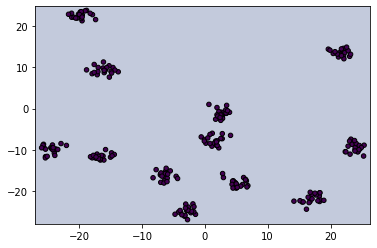

In [64]:
model.plot_decision_regions_2D(X)

In [65]:
model.optimize_k(X, max_k=15)

12

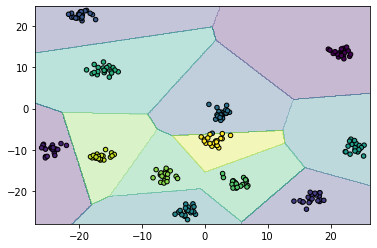

In [66]:
model.fit(X)
model.plot_decision_regions_2D(X)

In [67]:
model.predict(X)

array([11.,  8.,  9., 11., 11.,  3., 10., 11.,  7.,  1.,  1.,  8.,  5.,
        7.,  2.,  2.,  0.,  4.,  5.,  8.,  4.,  7.,  4.,  3.,  7.,  3.,
        5.,  7.,  2.,  6.,  3.,  9.,  6., 10.,  4.,  4., 11.,  3.,  8.,
        2.,  4.,  4.,  8.,  2.,  8.,  1.,  2.,  9., 11.,  5.,  4.,  2.,
       10.,  6.,  7.,  4.,  5.,  0., 10.,  6.,  5., 10.,  9., 10.,  5.,
        0.,  8.,  4.,  7., 10.,  4.,  4.,  8.,  3.,  5.,  9.,  0.,  0.,
        3.,  8., 11.,  1.,  1.,  3.,  4.,  0., 10.,  0.,  6.,  1.,  6.,
        1.,  2.,  7.,  4.,  7.,  0.,  0., 10.,  6.,  8.,  4., 11.,  0.,
        0.,  5.,  7.,  9.,  9.,  0., 11.,  8.,  3.,  6.,  3.,  8.,  4.,
       10.,  2.,  2.,  7.,  6.,  0., 11.,  0., 10.,  6.,  0., 10., 11.,
        9.,  1.,  5.,  9.,  9.,  0.,  6.,  2.,  1.,  9., 11.,  1.,  5.,
        6.,  6.,  9.,  8., 10., 11.,  9.,  4.,  7.,  3., 11.,  0.,  7.,
        1.,  4.,  2.,  5.,  8.,  6.,  5.,  5.,  8.,  5.,  7.,  5.,  2.,
        2.,  5.,  0.,  6.,  8.,  8.,  7.,  9.,  3.,  8.,  7., 11

In [69]:
model.predictions_dict(X)

defaultdict(list,
            {11: [array([ 1.70273705, -7.87481531]),
              array([ 1.11780226, -9.10410161]),
              array([ 1.86244216, -8.90715678]),
              array([ 1.48560188, -8.3774775 ]),
              array([-0.58637827, -6.86242399]),
              array([ 2.75127518, -7.29060303]),
              array([ 2.5258934 , -7.23976695]),
              array([ 1.93402114, -7.80560982]),
              array([-0.06027264, -7.48440522]),
              array([ 0.15309517, -8.38146459]),
              array([ 2.20541609, -9.5086774 ]),
              array([ 0.80463486, -6.26395779]),
              array([ 1.87764201, -8.87066493]),
              array([-0.09778342, -7.85659059]),
              array([ 4.08100748, -6.48855947]),
              array([ 0.45699771, -7.11562319]),
              array([ 0.80086542, -8.44414085]),
              array([ 2.76621644, -6.06496085]),
              array([ 1.94872167, -8.92895333]),
              array([ 1.83130524, -8.07331443])

In [85]:
model.silhouette_score(X)

0.8517943559006408

# 3D

In [74]:
X, y = make_blobs(n_samples = 250, n_features = 3, centers = 9, center_box = (-20, 20))

In [75]:
model = k_means_model(3)

<IPython.core.display.Javascript object>


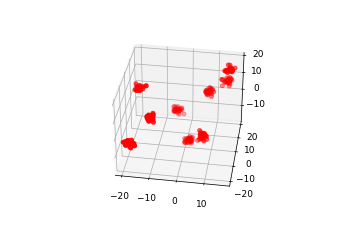

In [76]:
%matplotlib notebook
model.show_clusters_3D(X)

In [77]:
model.optimize_k(X)

9

In [78]:
model.fit(X)

<IPython.core.display.Javascript object>


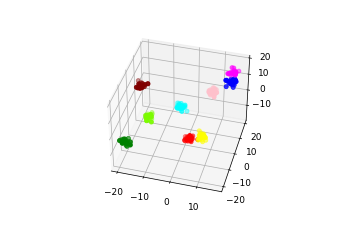

In [79]:
%matplotlib notebook
model.show_clusters_3D(X)

# 4D

In [80]:
X, y = make_blobs(n_samples = 350, n_features = 4, centers = 3, center_box = (-15, 15))

In [81]:
model = k_means_model(4)

In [82]:
model.optimize_k(X)

3

In [83]:
model.fit(X)

# 25 D

In [86]:
X, y = make_blobs(n_samples = 2500, n_features = 25, centers = 46, center_box = (-25, 25))

In [87]:
model = k_means_model(25)

In [88]:
model.optimize_k(X, max_k = 50)

46

In [89]:
model.fit(X)

# Irises

In [90]:
from sklearn import datasets
iris = datasets.load_iris()

In [91]:
X = iris["data"]
y = iris["target"]

In [92]:
model = k_means_model(4)

In [93]:
model.k = 3

In [94]:
model.fit(X)

In [95]:
y_pr = model.predict(X)

In [96]:
#ACCURACY
1 - (np.abs(np.count_nonzero(y_pr == 0) - 50) + np.abs(np.count_nonzero(y_pr == 1) - 50) + np.abs(np.count_nonzero(y_pr == 2) - 50))/300

0.8200000000000001